# Finetune VGG16


With 1000 x 400 melspectrogram images with online data augmentation (Gaussian noise addition)


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
FINETUNED_MODEL = 'vgg16_augmented_stochastic'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'

Custom dataset class for loading the mel spectrogram images


In [6]:
from datasets.MelspectrogramDataset import MelSpectrogramDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="Training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the validation function


In [8]:
def validate(model, valloader, criterion, device):
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    # Switch to evaluation mode
    model.eval()

    epoch_start = time.time()
    pbar = tqdm(enumerate(valloader), total=len(
        valloader), desc="Validating")

    with torch.no_grad():
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate time metrics
            elapsed = time.time() - epoch_start
            progress = (i + 1) / len(valloader)
            eta = elapsed / progress - elapsed

            # Update progress bar with current loss and ETA
            pbar.set_postfix({
                "Loss": f"{loss.item()}",
                "Elapsed": f"{elapsed:.4f}s",
                "ETA": f"{eta:.4f}s"
            })

    val_loss = val_loss / len(valloader)
    val_accuracy = val_correct / val_total * 100

    return val_loss, val_accuracy

Define what happens in each epoch


In [9]:
def train_epochs(model, trainloader, valloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(
            model, valloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(
            f'Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Check if current model is best performing using test_accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_{FINETUNED_MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }
            torch.save(checkpoint, f'best_{FINETUNED_MODEL}_checkpoint.pt')

    return model, train_losses, train_accuracies, val_losses, val_accuracies

Plot the loss and accuracy graphs


In [10]:
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(val_accuracies)),
             val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Define the model


In [12]:
model = models.vgg16(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [13]:
# Number of classes
num_classes = 9

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify final fully connected layer according to number of classes
num_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_features, num_classes)
# print("Modified model")
# print(model)

# Unfreeze the final fully connected layer so it will be trained
for param in model.classifier[-1].parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Define a class to add Gaussian noise to the mel spectrogram images for online data augmentation


In [14]:
from data_augmentation.AddGaussianNoiseStochastic import AddGaussianNoiseStochastic

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [15]:
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define train transformations, also the online data augmentation
train_transform = transforms.Compose([
    # Resize the Mel spectrogram to 224x224, suitable for VGG16
    transforms.Resize((224, 224)),
    transforms.ToTensor(),          # Convert to Tensor
    AddGaussianNoiseStochastic(mean=0.0, std_range=(0.0, 0.03), p=0.5
                               ),  # Online noise augmentation
    # Normalize to ImageNet stats
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define test transformations for both validation and test sets
test_transform = transforms.Compose([
    # Resize the Mel spectrogram to 224x224, suitable for VGG16
    transforms.Resize((224, 224)),
    transforms.ToTensor(),          # Convert to Tensor
    # Normalize to ImageNet stats
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])

epochs = 25

Execute the fine-tuning


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.84it/s, Loss=2.0199997425079346, Elapsed=26.4070s, ETA=0.0000s] 


Epoch 1 completed in 105.3386s
Train Loss: 1.447153175841866 - Train Accuracy: 42.62002216141652
Validation Loss: 1.2816739813486735 - Validation Accuracy: 50.86534402701561

Epoch 2/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.90it/s, Loss=1.5135600566864014, Elapsed=26.3651s, ETA=0.0000s] 


Epoch 2 completed in 103.5555s
Train Loss: 1.3637797649885188 - Train Accuracy: 46.032428031930536
Validation Loss: 1.248670851389567 - Validation Accuracy: 51.10806247361756

Epoch 3/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.79it/s, Loss=1.863871455192566, Elapsed=26.7508s, ETA=0.0000s]  


Epoch 3 completed in 103.9322s
Train Loss: 1.3489337070828917 - Train Accuracy: 46.48696320752584
Validation Loss: 1.2270802545547486 - Validation Accuracy: 52.77543267201351

Epoch 4/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.88it/s, Loss=1.6756004095077515, Elapsed=26.3639s, ETA=0.0000s] 


Epoch 4 completed in 103.8506s
Train Loss: 1.341837992213365 - Train Accuracy: 47.0251690373352
Validation Loss: 1.2070264355341593 - Validation Accuracy: 54.02068383284087

Epoch 5/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.81it/s, Loss=1.8113933801651, Elapsed=26.4656s, ETA=0.0000s]    


Epoch 5 completed in 103.8190s
Train Loss: 1.3367243908733302 - Train Accuracy: 47.1879876076977
Validation Loss: 1.2278584782282511 - Validation Accuracy: 51.47741663149008

Epoch 6/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.83it/s, Loss=1.7012670040130615, Elapsed=26.5153s, ETA=0.0000s] 


Epoch 6 completed in 103.8687s
Train Loss: 1.341158924419756 - Train Accuracy: 47.282965107075825
Validation Loss: 1.2152285623550414 - Validation Accuracy: 53.176445757703675

Epoch 7/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.83it/s, Loss=1.644498348236084, Elapsed=26.3599s, ETA=0.0000s]  


Epoch 7 completed in 103.8575s
Train Loss: 1.3380956491293934 - Train Accuracy: 47.24452183351801
Validation Loss: 1.201302588780721 - Validation Accuracy: 53.925707049387924

Epoch 8/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.83it/s, Loss=1.6535439491271973, Elapsed=26.3866s, ETA=0.0000s] 


Epoch 8 completed in 103.7417s
Train Loss: 1.3275881106453824 - Train Accuracy: 47.527192962619566
Validation Loss: 1.2150308974583943 - Validation Accuracy: 53.11312790206838

Epoch 9/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.93it/s, Loss=1.7118712663650513, Elapsed=26.0530s, ETA=0.0000s] 


Epoch 9 completed in 103.1575s
Train Loss: 1.339186121962663 - Train Accuracy: 47.28070373804301
Validation Loss: 1.1861701186498006 - Validation Accuracy: 54.27395525538202

Epoch 10/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.84it/s, Loss=1.7500118017196655, Elapsed=26.3049s, ETA=0.0000s] 


Epoch 10 completed in 113.3612s
Train Loss: 1.3272166944652624 - Train Accuracy: 47.66739784265394
Validation Loss: 1.2010346031188965 - Validation Accuracy: 53.060363022372314

Epoch 11/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.92it/s, Loss=2.006235122680664, Elapsed=26.2337s, ETA=0.0000s]  


Epoch 11 completed in 103.3419s
Train Loss: 1.3345243362333044 - Train Accuracy: 47.51588611745551
Validation Loss: 1.2119956636428832 - Validation Accuracy: 53.345293372731106

Epoch 12/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.80it/s, Loss=1.5919734239578247, Elapsed=26.3256s, ETA=0.0000s] 


Epoch 12 completed in 103.5972s
Train Loss: 1.3359598500191132 - Train Accuracy: 47.40281766581489
Validation Loss: 1.1985676662127176 - Validation Accuracy: 53.58801181933305

Epoch 13/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.86it/s, Loss=1.5024068355560303, Elapsed=26.3426s, ETA=0.0000s] 


Epoch 13 completed in 104.3573s
Train Loss: 1.33694558922266 - Train Accuracy: 47.15632844123833
Validation Loss: 1.187252351442973 - Validation Accuracy: 54.252849303503595

Epoch 14/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.83it/s, Loss=1.6516928672790527, Elapsed=26.3594s, ETA=0.0000s] 


Epoch 14 completed in 103.4318s
Train Loss: 1.3302971620780195 - Train Accuracy: 47.809864091721124
Validation Loss: 1.2093744548161824 - Validation Accuracy: 53.303081468974256

Epoch 15/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.86it/s, Loss=1.467832088470459, Elapsed=26.3216s, ETA=0.0000s]  


Epoch 15 completed in 104.1748s
Train Loss: 1.335470117240972 - Train Accuracy: 47.450306415503945
Validation Loss: 1.19369055668513 - Validation Accuracy: 53.883495145631066

Epoch 16/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.85it/s, Loss=1.7371325492858887, Elapsed=26.4356s, ETA=0.0000s] 


Epoch 16 completed in 103.7107s
Train Loss: 1.3370370162015706 - Train Accuracy: 47.29879469030551
Validation Loss: 1.1975083001454672 - Validation Accuracy: 54.485014774166316

Epoch 17/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.88it/s, Loss=1.6136407852172852, Elapsed=26.2670s, ETA=0.0000s] 


Epoch 17 completed in 104.1305s
Train Loss: 1.3378813773221363 - Train Accuracy: 47.4231699871102
Validation Loss: 1.1858970244725546 - Validation Accuracy: 54.66441536513297

Epoch 18/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.83it/s, Loss=1.5058687925338745, Elapsed=26.4060s, ETA=0.0000s] 


Epoch 18 completed in 104.1871s
Train Loss: 1.3255682060484253 - Train Accuracy: 47.71940933040863
Validation Loss: 1.1771985165278116 - Validation Accuracy: 54.886027859856476

Epoch 19/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.88it/s, Loss=1.831540822982788, Elapsed=26.2259s, ETA=0.0000s]  


Epoch 19 completed in 104.0007s
Train Loss: 1.3338847787394 - Train Accuracy: 47.76463671106488
Validation Loss: 1.1989574114481607 - Validation Accuracy: 53.767412410299706

Epoch 20/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.89it/s, Loss=1.419739842414856, Elapsed=26.2324s, ETA=0.0000s]  


Epoch 20 completed in 103.7574s
Train Loss: 1.332886724113729 - Train Accuracy: 47.678704687818005
Validation Loss: 1.1793331988652547 - Validation Accuracy: 54.896580835795696

Epoch 21/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.82it/s, Loss=1.3579301834106445, Elapsed=26.4390s, ETA=0.0000s] 


Epoch 21 completed in 103.7751s
Train Loss: 1.3353022977795903 - Train Accuracy: 47.61312498586644
Validation Loss: 1.1755200465520224 - Validation Accuracy: 55.14985225833685

Epoch 22/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.85it/s, Loss=1.614315152168274, Elapsed=26.2884s, ETA=0.0000s]  


Epoch 22 completed in 103.7174s
Train Loss: 1.3351664581050762 - Train Accuracy: 47.49327242712738
Validation Loss: 1.2009948142369589 - Validation Accuracy: 52.80709159983116

Epoch 23/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.86it/s, Loss=1.699127197265625, Elapsed=26.2675s, ETA=0.0000s]  


Epoch 23 completed in 103.7662s
Train Loss: 1.3343922967855641 - Train Accuracy: 47.504579272291444
Validation Loss: 1.18834219455719 - Validation Accuracy: 54.13676656817222

Epoch 24/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.77it/s, Loss=1.8287324905395508, Elapsed=27.1993s, ETA=0.0000s]  


Epoch 24 completed in 105.2589s
Train Loss: 1.3335711191155317 - Train Accuracy: 47.411863141946135
Validation Loss: 1.1937767807642619 - Validation Accuracy: 53.65132967496834

Epoch 25/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.83it/s, Loss=1.6363855600357056, Elapsed=26.4047s, ETA=0.0000s] 


Epoch 25 completed in 103.9011s
Train Loss: 1.3360946970867973 - Train Accuracy: 47.543022545849254
Validation Loss: 1.186810212135315 - Validation Accuracy: 54.474461798227104



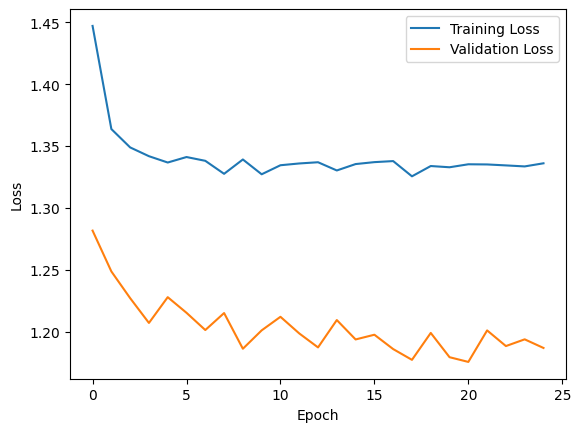

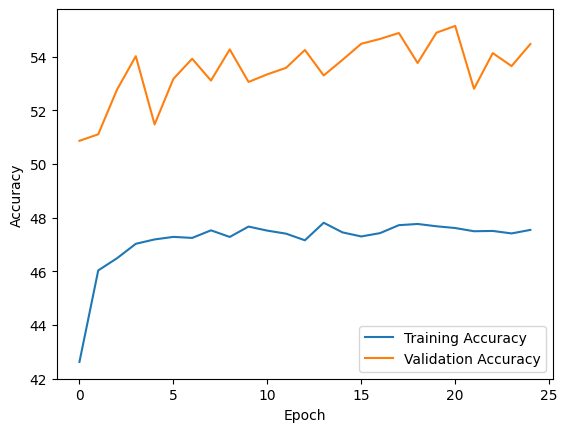

In [16]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=train_transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=test_transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=test_transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model, trainloader, valloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{FINETUNED_MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

Define the function to plot the confusion matrix


In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

Define the function to evaluate the best model on the test set


In [18]:
def load_and_evaluate_best_model(model, testloader, criterion, device, model_path):
    # Load the best model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_labels = []
    running_loss = 0.0
    correct = 0
    total = 0

    print("Evaluating best model on test set...")
    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate final metrics
    test_loss = running_loss / len(testloader)
    test_accuracy = 100 * correct / total

    print(f"\nTest Results (Best Model):")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    return test_loss, test_accuracy, all_preds, all_labels

Evaluate the best model on the test set


C:\Users\profi\AppData\Local\Temp\ipykernel_8020\3579996063.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:27<00:00,  2.73it/s]



Test Results (Best Model):
Test Loss: 1.1607
Test Accuracy: 55.18%


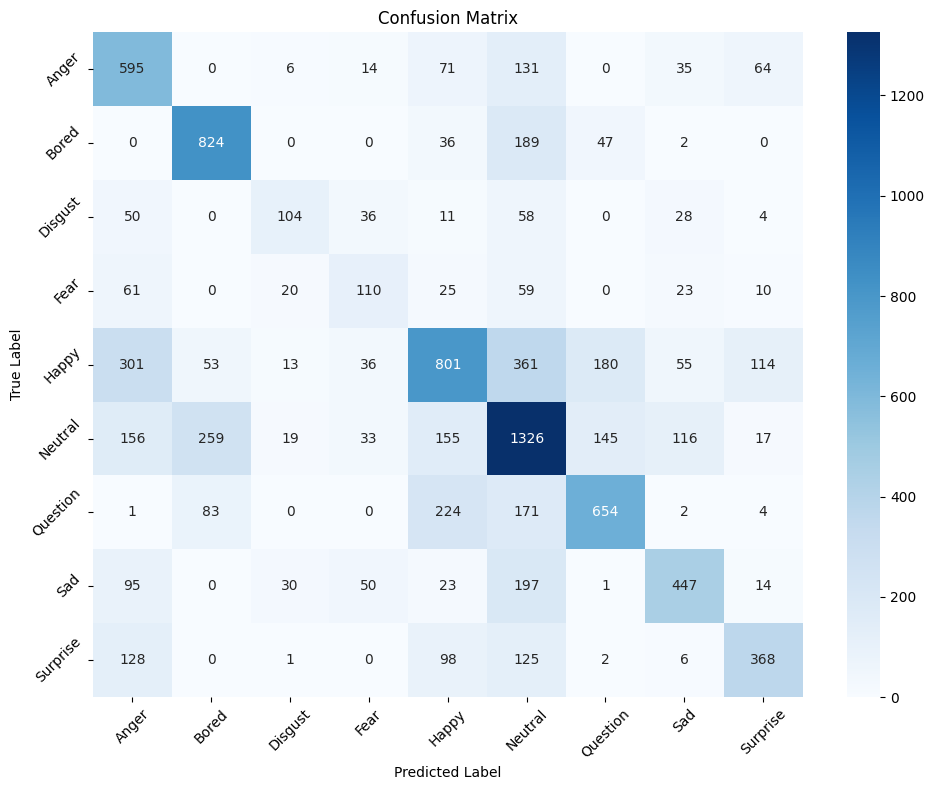

In [19]:
# Load and evaluate the best model
best_model_path = f'best_{FINETUNED_MODEL}.pt'
test_loss, test_accuracy, all_preds, all_labels = load_and_evaluate_best_model(
    model=model,
    testloader=testloader,
    criterion=criterion,
    device=device,
    model_path=best_model_path
)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)